# Input Target Pairs

In this section we implement a data loader that fetches the input-target pairs using a sliding window approach.

To get started, we will first tokenize the whole The Verdict short story we worked with earlier using the BPE tokenizer introduced in the previous section:

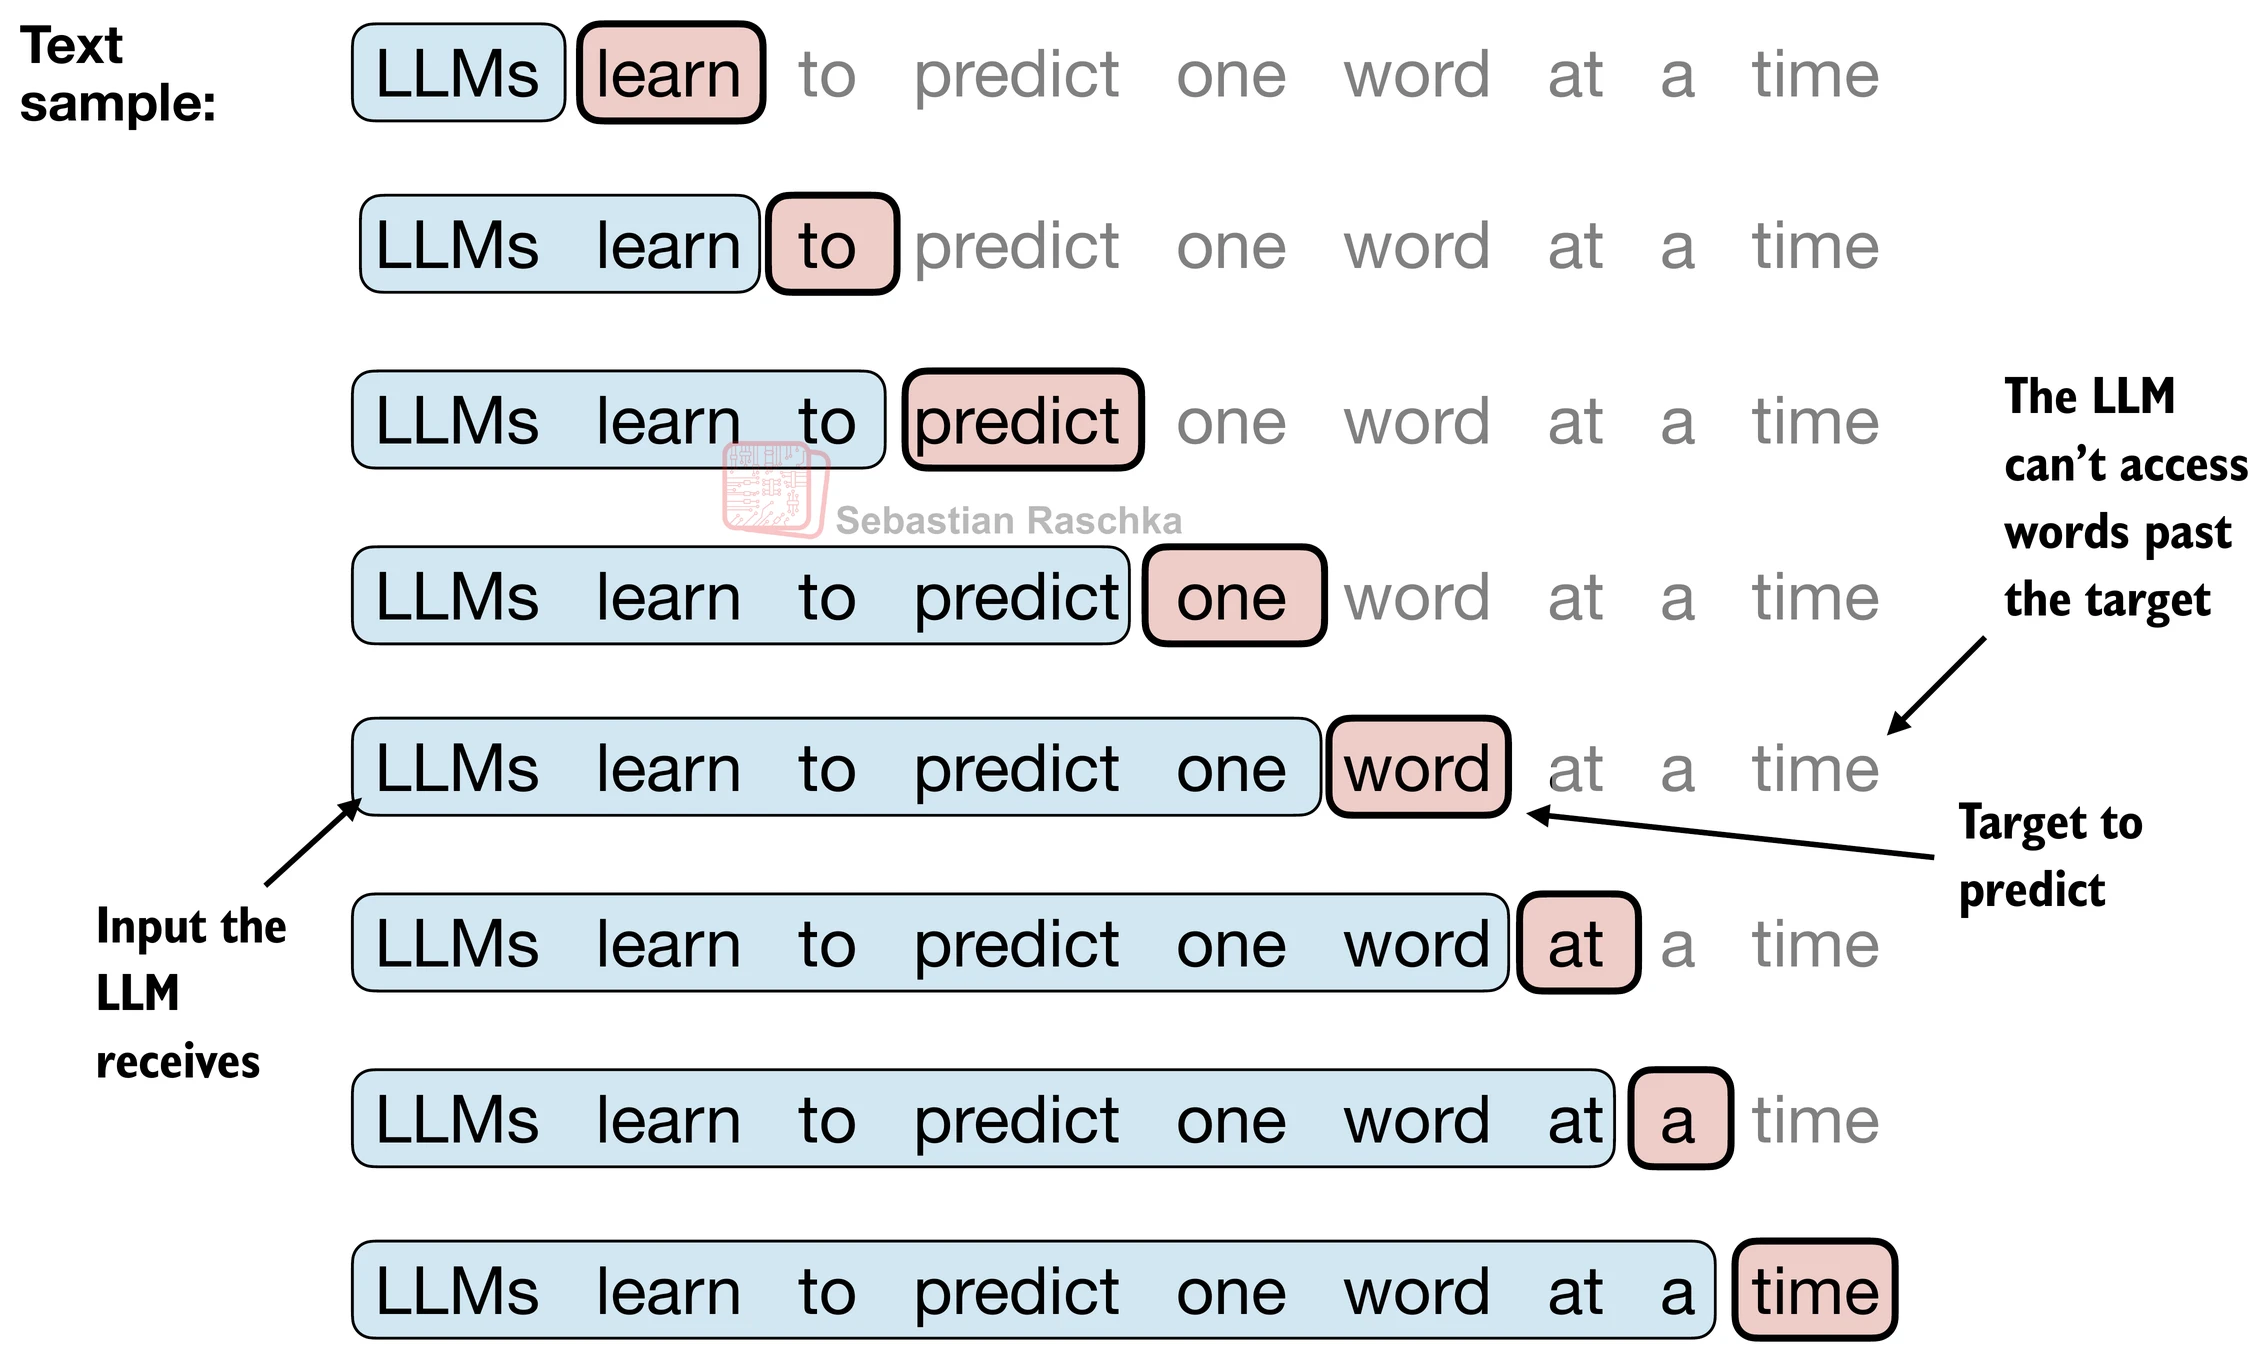

In [76]:
import tiktoken

In [77]:
tokenizer = tiktoken.get_encoding('gpt2')

In [78]:
with open("the verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5145



Next, we remove the first 50 tokens from the dataset for demonstration purposes as it
results in a slightly more interesting text passage in the next steps:

In [79]:
enc_sample = enc_text[50:]
print(len(enc_sample))

5095


One of the easiest and most intuitive ways to create the input-target pairs for the nextword prediction task is to create two variables, x and y, where x contains the input tokens and y contains the targets, which are the inputs shifted by 1:


The context size determines how many tokens are included in the input

In [80]:
context_size = 4 # Length of the input
#The context_size of 4 means that the model is trained to look at a sequence of 4 words (or tokens) 
#to predict the next word in the sequence. 
#The input x is the first 4 tokens [1, 2, 3, 4], and the target y is the next 4 tokens [2, 3, 4, 5]

x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]

print(f"x: {x}")
print(f"Y: {y}")


x: [290, 4920, 2241, 287]
Y: [4920, 2241, 287, 257]


Processing the inputs along with the targets, which are the inputs shifted by one position, we can then create the next-word prediction tasks as follows:

In [81]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(context, "---->", desired)

[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257


Everything left of the arrow (---->) refers to the input an LLM would receive, and the token ID on the right side of the arrow represents the target token ID that the LLM is supposed to predict.


For illustration purposes, let's repeat the previous code but convert the token IDs into text:


In [82]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


We've now created the input-target pairs that we can turn into use for the LLM training in upcoming chapters.

There's only one more task before we can turn the tokens into embeddings:implementing an efficient data loader that iterates over the input dataset and returns the inputs and targets as PyTorch tensors, which can be thought of as multidimensional arrays.

In particular, we are interested in returning two tensors: an input tensor containing the text that the LLM sees and a target tensor that includes the targets for the LLM to predict,

# Implementing a Data Loader

For the efficient data loader implementation, we will use PyTorch's built-in Dataset and DataLoader classes.


Step 1: Tokenize the entire text

Step 2: Use a sliding window to chunk the book into overlapping sequences of max_length

Step 3: Return the total number of rows in the dataset

Step 4: Return a single row from the dataset

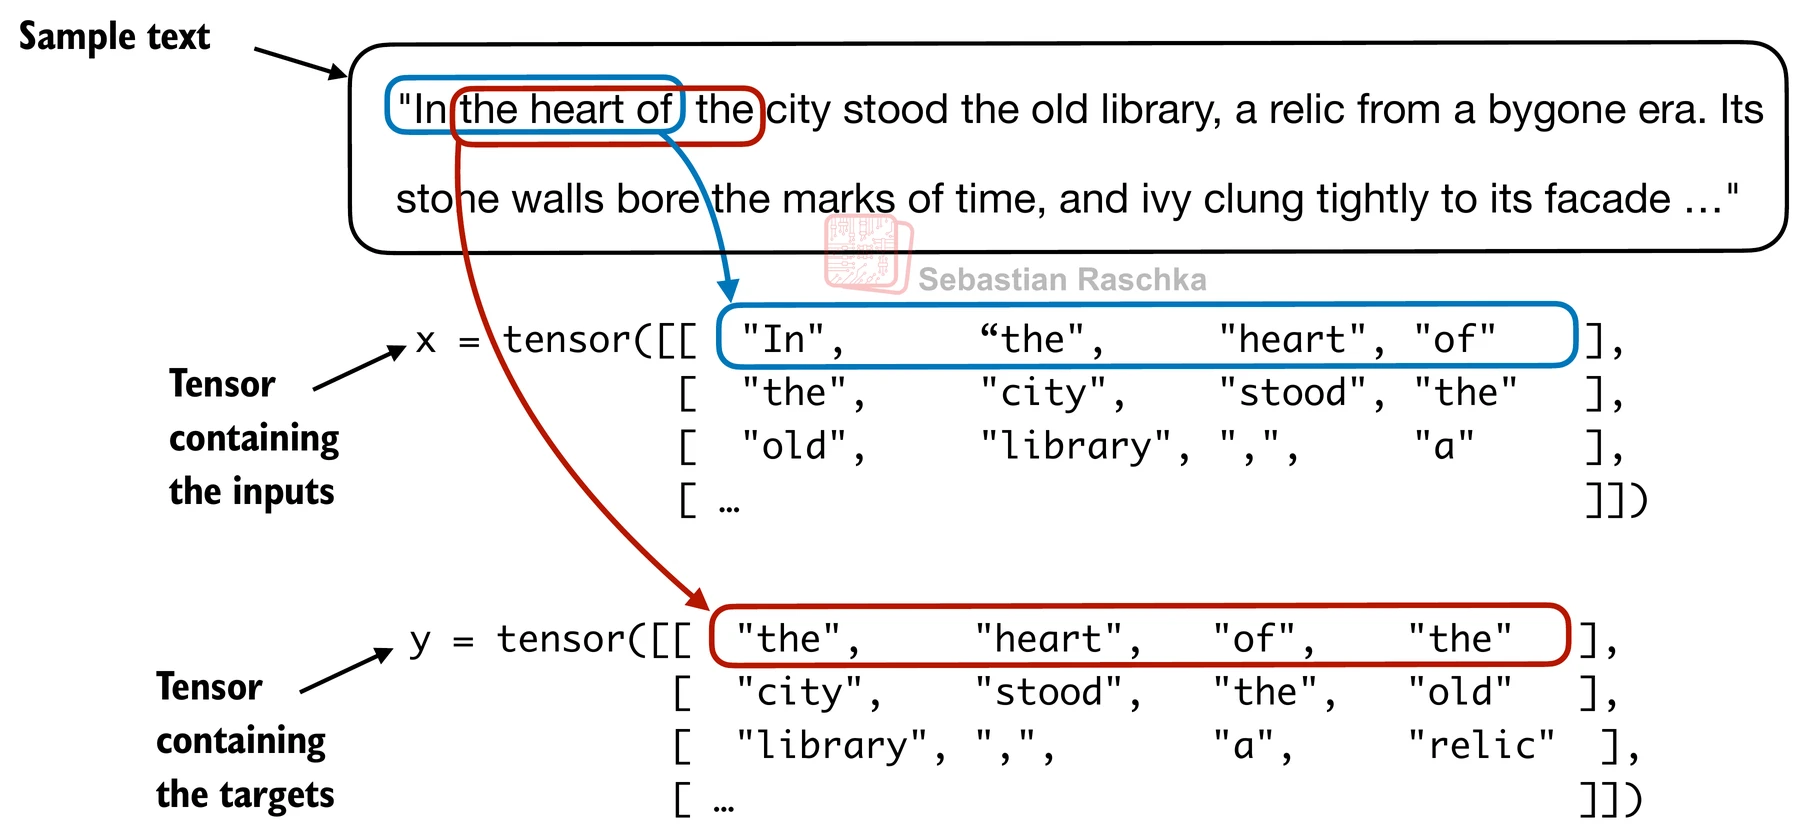

In [83]:
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride): # text file, BytePair tokenizer, context length, stride - how much you “slide” the window over the text when creating sequences
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special = {"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i  + max_length]
            target_chunk = token_ids[i+ 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))


    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]  

The GPTDatasetV1 class in listing 2.5 is based on the PyTorch Dataset class.

It defines how individual rows are fetched from the dataset.

Each row consists of a number of token IDs (based on a max_length) assigned to an input_chunk tensor.

The target_chunk tensor contains the corresponding targets.

I recommend reading on to see how the data returned from this dataset looks like when we combine the dataset with a PyTorch DataLoader -- this will bring additional intuition and clarity.

The following code will use the GPTDatasetV1 to load the inputs in batches via a PyTorch DataLoader:

- Step 1: Initialize the tokenizer

- Step 2: Create dataset

- Step 3: drop_last=True drops the last batch if it is shorter than the specified batch_size to prevent loss spikes during training

- Step 4: The number of CPU processes to use for preprocessing

In [84]:
def create_dataloader_v1(txt, batch_size = 4, max_length = 256,
                         stride = 128, shuffle = True, drop_last = True,
                         num_workers = 0):
    
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader

    dataloader = DataLoader(
        dataset,
        batch_size = batch_size,
        shuffle = shuffle,
        drop_last = drop_last,
        num_workers = num_workers
    )

    return dataloader
    

Let's test the dataloader with a batch size of 1 for an LLM with a context size of 4,

This will develop an intuition of how the GPTDatasetV1 class and the create_dataloader_v1 function work together:

In [85]:
with open("the verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

Convert dataloader into a Python iterator to fetch the next entry via Python's built-in next() function

In [86]:
import torch
print("PyTorch version:", torch.__version__)

dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle= False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

PyTorch version: 2.9.0+cpu
[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


The first_batch variable contains two tensors: the first tensor stores the input token IDs, and the second tensor stores the target token IDs.

Since the max_length is set to 4, each of the two tensors contains 4 token IDs.

Note that an input size of 4 is relatively small and only chosen for illustration purposes. It is common to train LLMs with input sizes of at least 256.

To illustrate the meaning of stride=1, let's fetch another batch from this dataset:

In [87]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


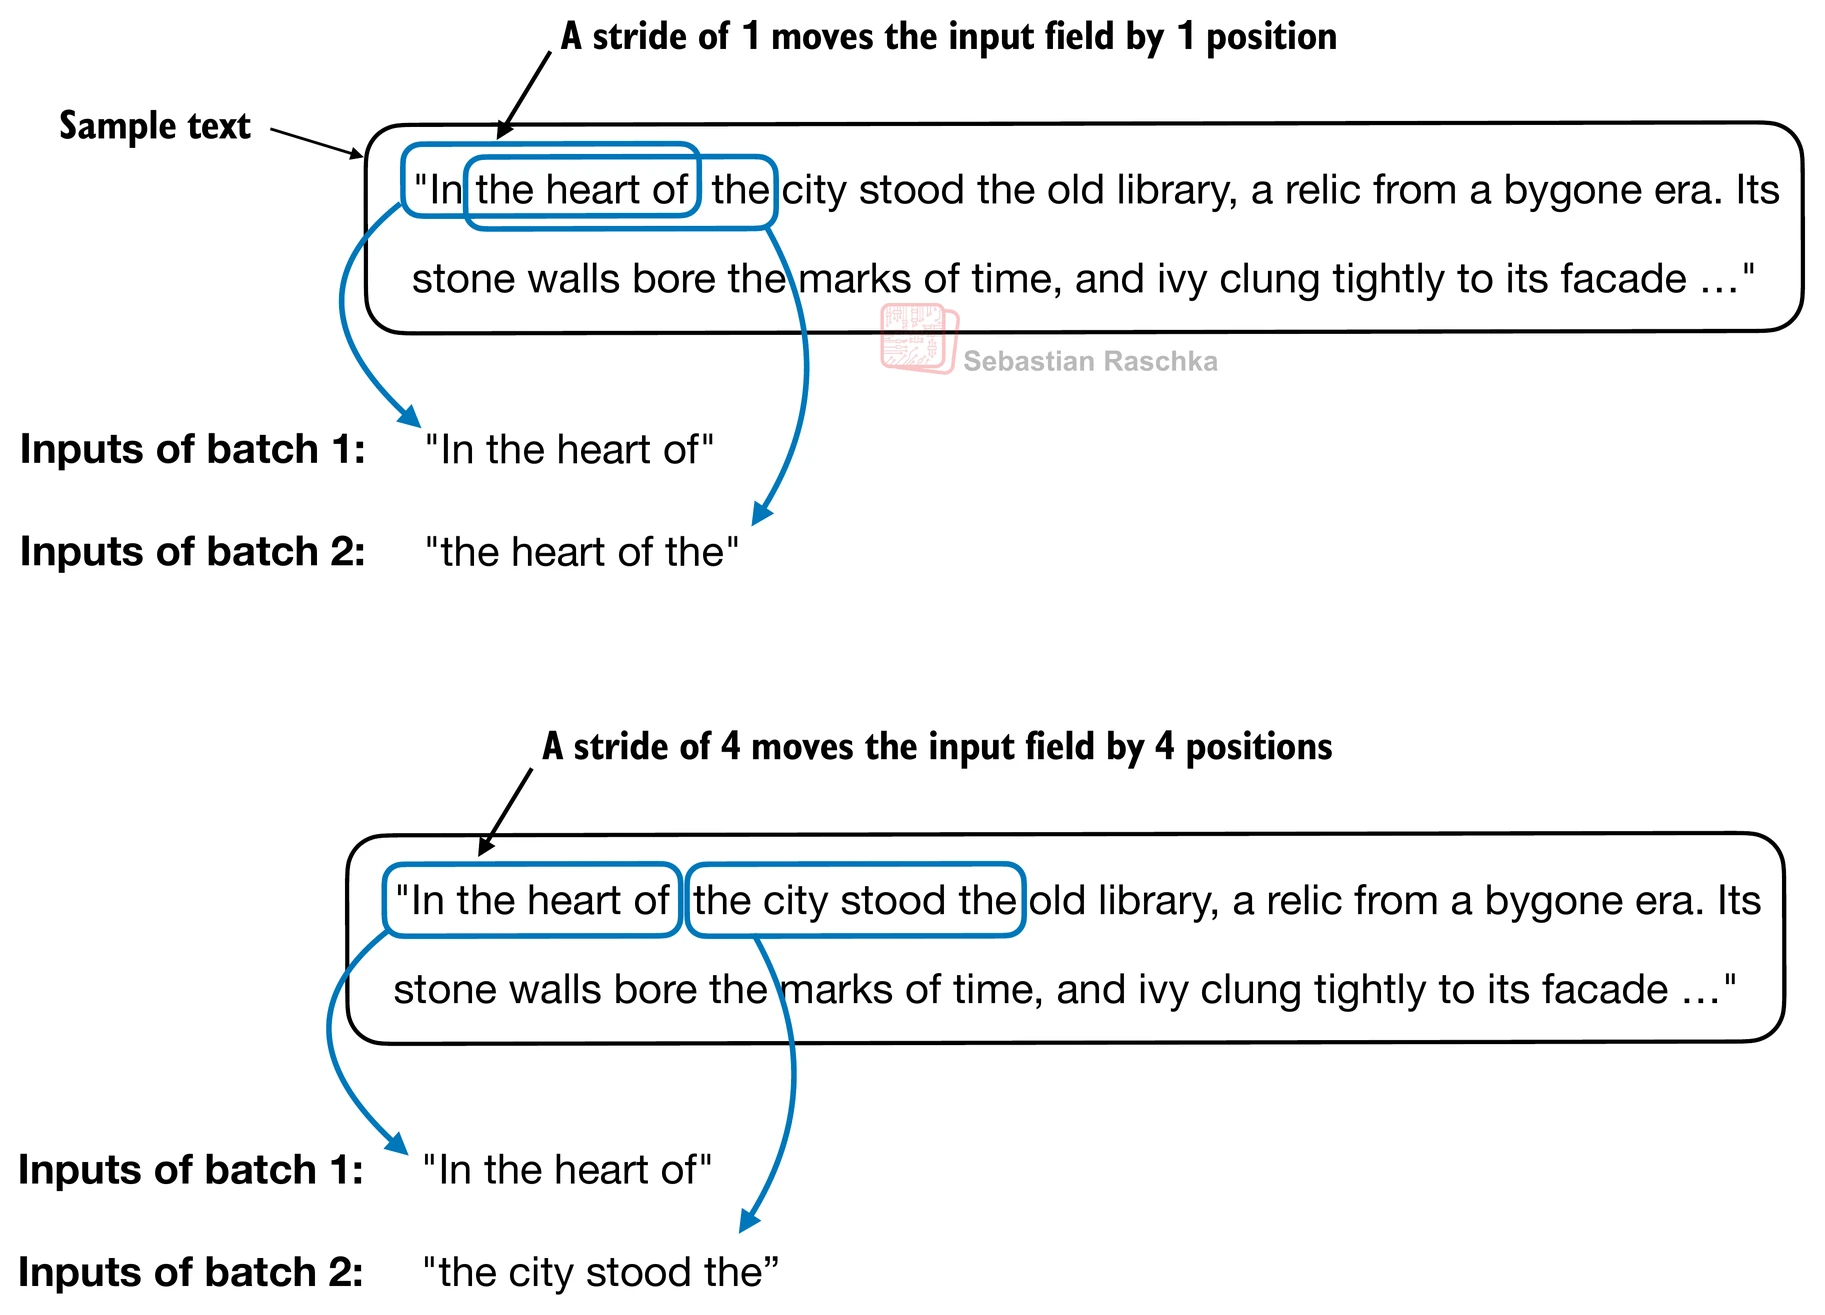

If we compare the first with the second batch, we can see that the second batch's token IDs are shifted by one position compared to the first batch.

For example, the second ID in the first batch's input is 367, which is the first ID of the second batch's input.

The stride setting dictates the number of positions the inputs shift across batches, emulating a sliding window approach

Batch sizes of 1, such as we have sampled from the data loader so far, are useful for illustration purposes.

If you have previous experience with deep learning, you may know that small batch sizes require less memory during training but lead to more noisy model updates.

Just like in regular deep learning, the batch size is a trade-off and hyperparameter to experiment with when training LLMs.

Before we move on to the two final sections of this chapter that are focused on creating the embedding vectors from the token IDs, let's have a brief look at how we can use the data loader to sample with a batch size greater than 1:

In [88]:
dataloader = create_dataloader_v1(raw_text, batch_size = 8, max_length= 4, stride = 4, shuffle = False )

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs: \n", inputs)
print("Outputs: \n", targets)

Inputs: 
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])
Outputs: 
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


Note that we increase the stride to 4. This is to utilize the data set fully (we don't skip a single word) but also avoid any overlap between the batches, since more overlap could lead to increased overfitting.